In [1]:
import os
import IPython
from ipywidgets import interact, IntSlider, Dropdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import matplotlib.image as mpimg
from tabulate import tabulate
import librosa
from sklearn.preprocessing import StandardScaler

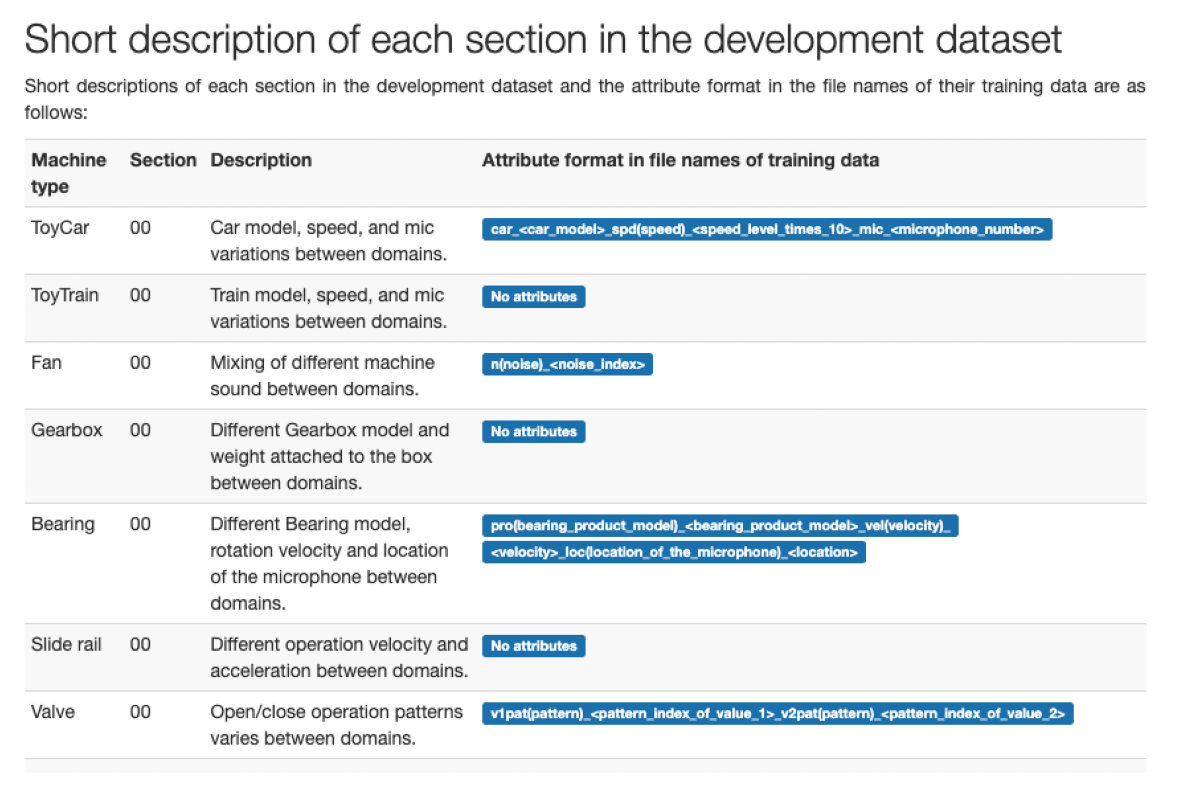

In [2]:
# Read Images
plt.figure(figsize=(15,15))
img = mpimg.imread('attributes.png')
plt.axis("off")
plt.imshow(img)

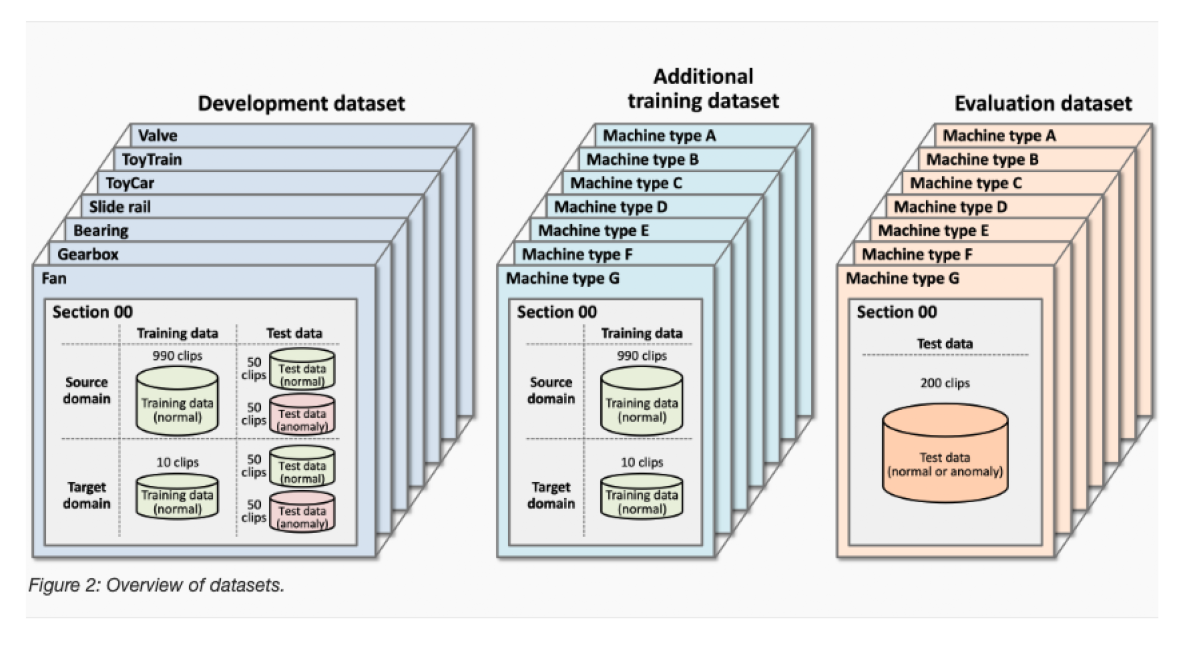

In [3]:
# Read Images
plt.figure(figsize=(15,15))
img = mpimg.imread('data_img.png')
plt.axis("off")
plt.imshow(img)

In [8]:
#get all the path of the file
develop_name = "develop"
current_path = os.getcwd()
dev_path = os.path.join(os.path.dirname(current_path) , "data", develop_name)

#choices
machine_choice = [i for i in os.listdir(dev_path) if (".DS_Store" not in i) and  "." not in i]
data_choice = ["train", "test"]
domain_choice = ["source","target"]
condition_choice = ["normal", "anomaly"]

In [ ]:
#get the files name based on machine, data, domain and type choices
def sub_df_from_name (df:pd.DataFrame,name:str):
    indices = []
    for file in df["file_name"].tolist():
        if name in file:
            idx = df["file_name"].tolist().index(file)
            indices.append(idx)

    return df.iloc[indices]

def concat_key(*args):
    key = ""
    for arg in args:
        key = key + arg + "_"

    return key[:-1]

def create_dict_unique_count(dev_path, machine_choice):

    # attribute file 
    name_attributt = "attributes_00.csv"

    # create dict unique count
    dict_unique_count = {}
    
    #machine type
    for machine in machine_choice:
        attributt_path = os.path.join(dev_path,machine,name_attributt)
        df = pd.read_csv(attributt_path)

        #data type
        for type in ["train","test"]:
            sub_df_type = sub_df_from_name(df,type)

            #domain type
            for domain in ["source","target"]:
                sub_df_domain = sub_df_from_name(sub_df_type,domain)
                
                #condition type
                for condition in ["normal","anomaly"]:
                    
                    sub_df_condition = sub_df_from_name(sub_df_domain,condition)
                    if len (sub_df_condition) > 0:

                        #create dict of dict unique count based on keys
                        key = concat_key(machine,type, domain, condition)
                        dict_unique_count[key] = {}

                        arr_attribute = np.array(sub_df_condition.loc[:,sub_df_condition.columns[1:]]) 
                        arr_attribute = np.array (["_".join(str(j) for j in i) for i in arr_attribute ])

                        unique_attributes, counts = np.unique(arr_attribute, return_counts=True)
                        
                        if len(unique_attributes) == 1:
                            unique_attributes = ["noAttribute"]

                        for i in range(len(unique_attributes)):
                            att = unique_attributes[i]
                            count = counts[i] 
                            dict_unique_count[key][att] = count
        
    return dict_unique_count

dict_unique_count = create_dict_unique_count(dev_path,machine_choice)

#visualize as tabular
def visualize_tabular (dict_unique_count):
    tab_dict = {}

    tab_dict["Machine"] = []
    tab_dict["Data"] =  []
    tab_dict["Domain"] =  []
    tab_dict["Condition"] =  []
    tab_dict["Attributes"] = []
    tab_dict["Counts"] = []

    for key_out in dict_unique_count.keys():
        split_key = key_out.split("_")
        machine, data, domain, condition = split_key[0],split_key[1],split_key[2],split_key[3]
        list_key_in = dict_unique_count[key_out].keys()
        
        for key_in in list_key_in:
            tab_dict["Machine"].append(machine)
            tab_dict["Data"].append(data)
            tab_dict["Domain"].append(domain)
            tab_dict["Condition"].append(condition)

            tab_dict["Attributes"].append(key_in)
            tab_dict["Counts"].append(dict_unique_count[key_out][key_in])
            
    return tab_dict

tabular_dict = visualize_tabular(dict_unique_count)
tabular = tabulate(tabular_data=tabular_dict,headers="keys")
print(tabular)
 
#save tabel as csv file
df_table = pd.DataFrame(tabular_dict)
df_name = "data_info.csv"
df_table.to_csv(df_name,index=False)

dev_path /home/phamanh/nobackup/DCASE2024/data/develop
machine_choice ['bearing', 'ToyTrain', 'slider', 'fan', 'gearbox', 'ToyCar', 'valve']
Machine    Data    Domain    Condition    Attributes                  Counts
---------  ------  --------  -----------  ------------------------  --------
bearing    train   source    normal       pro_A_vel_12_loc_A              62
bearing    train   source    normal       pro_A_vel_12_loc_B              62
bearing    train   source    normal       pro_A_vel_12_loc_C              62
bearing    train   source    normal       pro_A_vel_12_loc_D              62
bearing    train   source    normal       pro_A_vel_4_loc_A               61
bearing    train   source    normal       pro_A_vel_4_loc_B               62
bearing    train   source    normal       pro_A_vel_4_loc_C               62
bearing    train   source    normal       pro_A_vel_4_loc_D               62
bearing    train   source    normal       pro_B_vel_16_loc_A              62
bearing    t

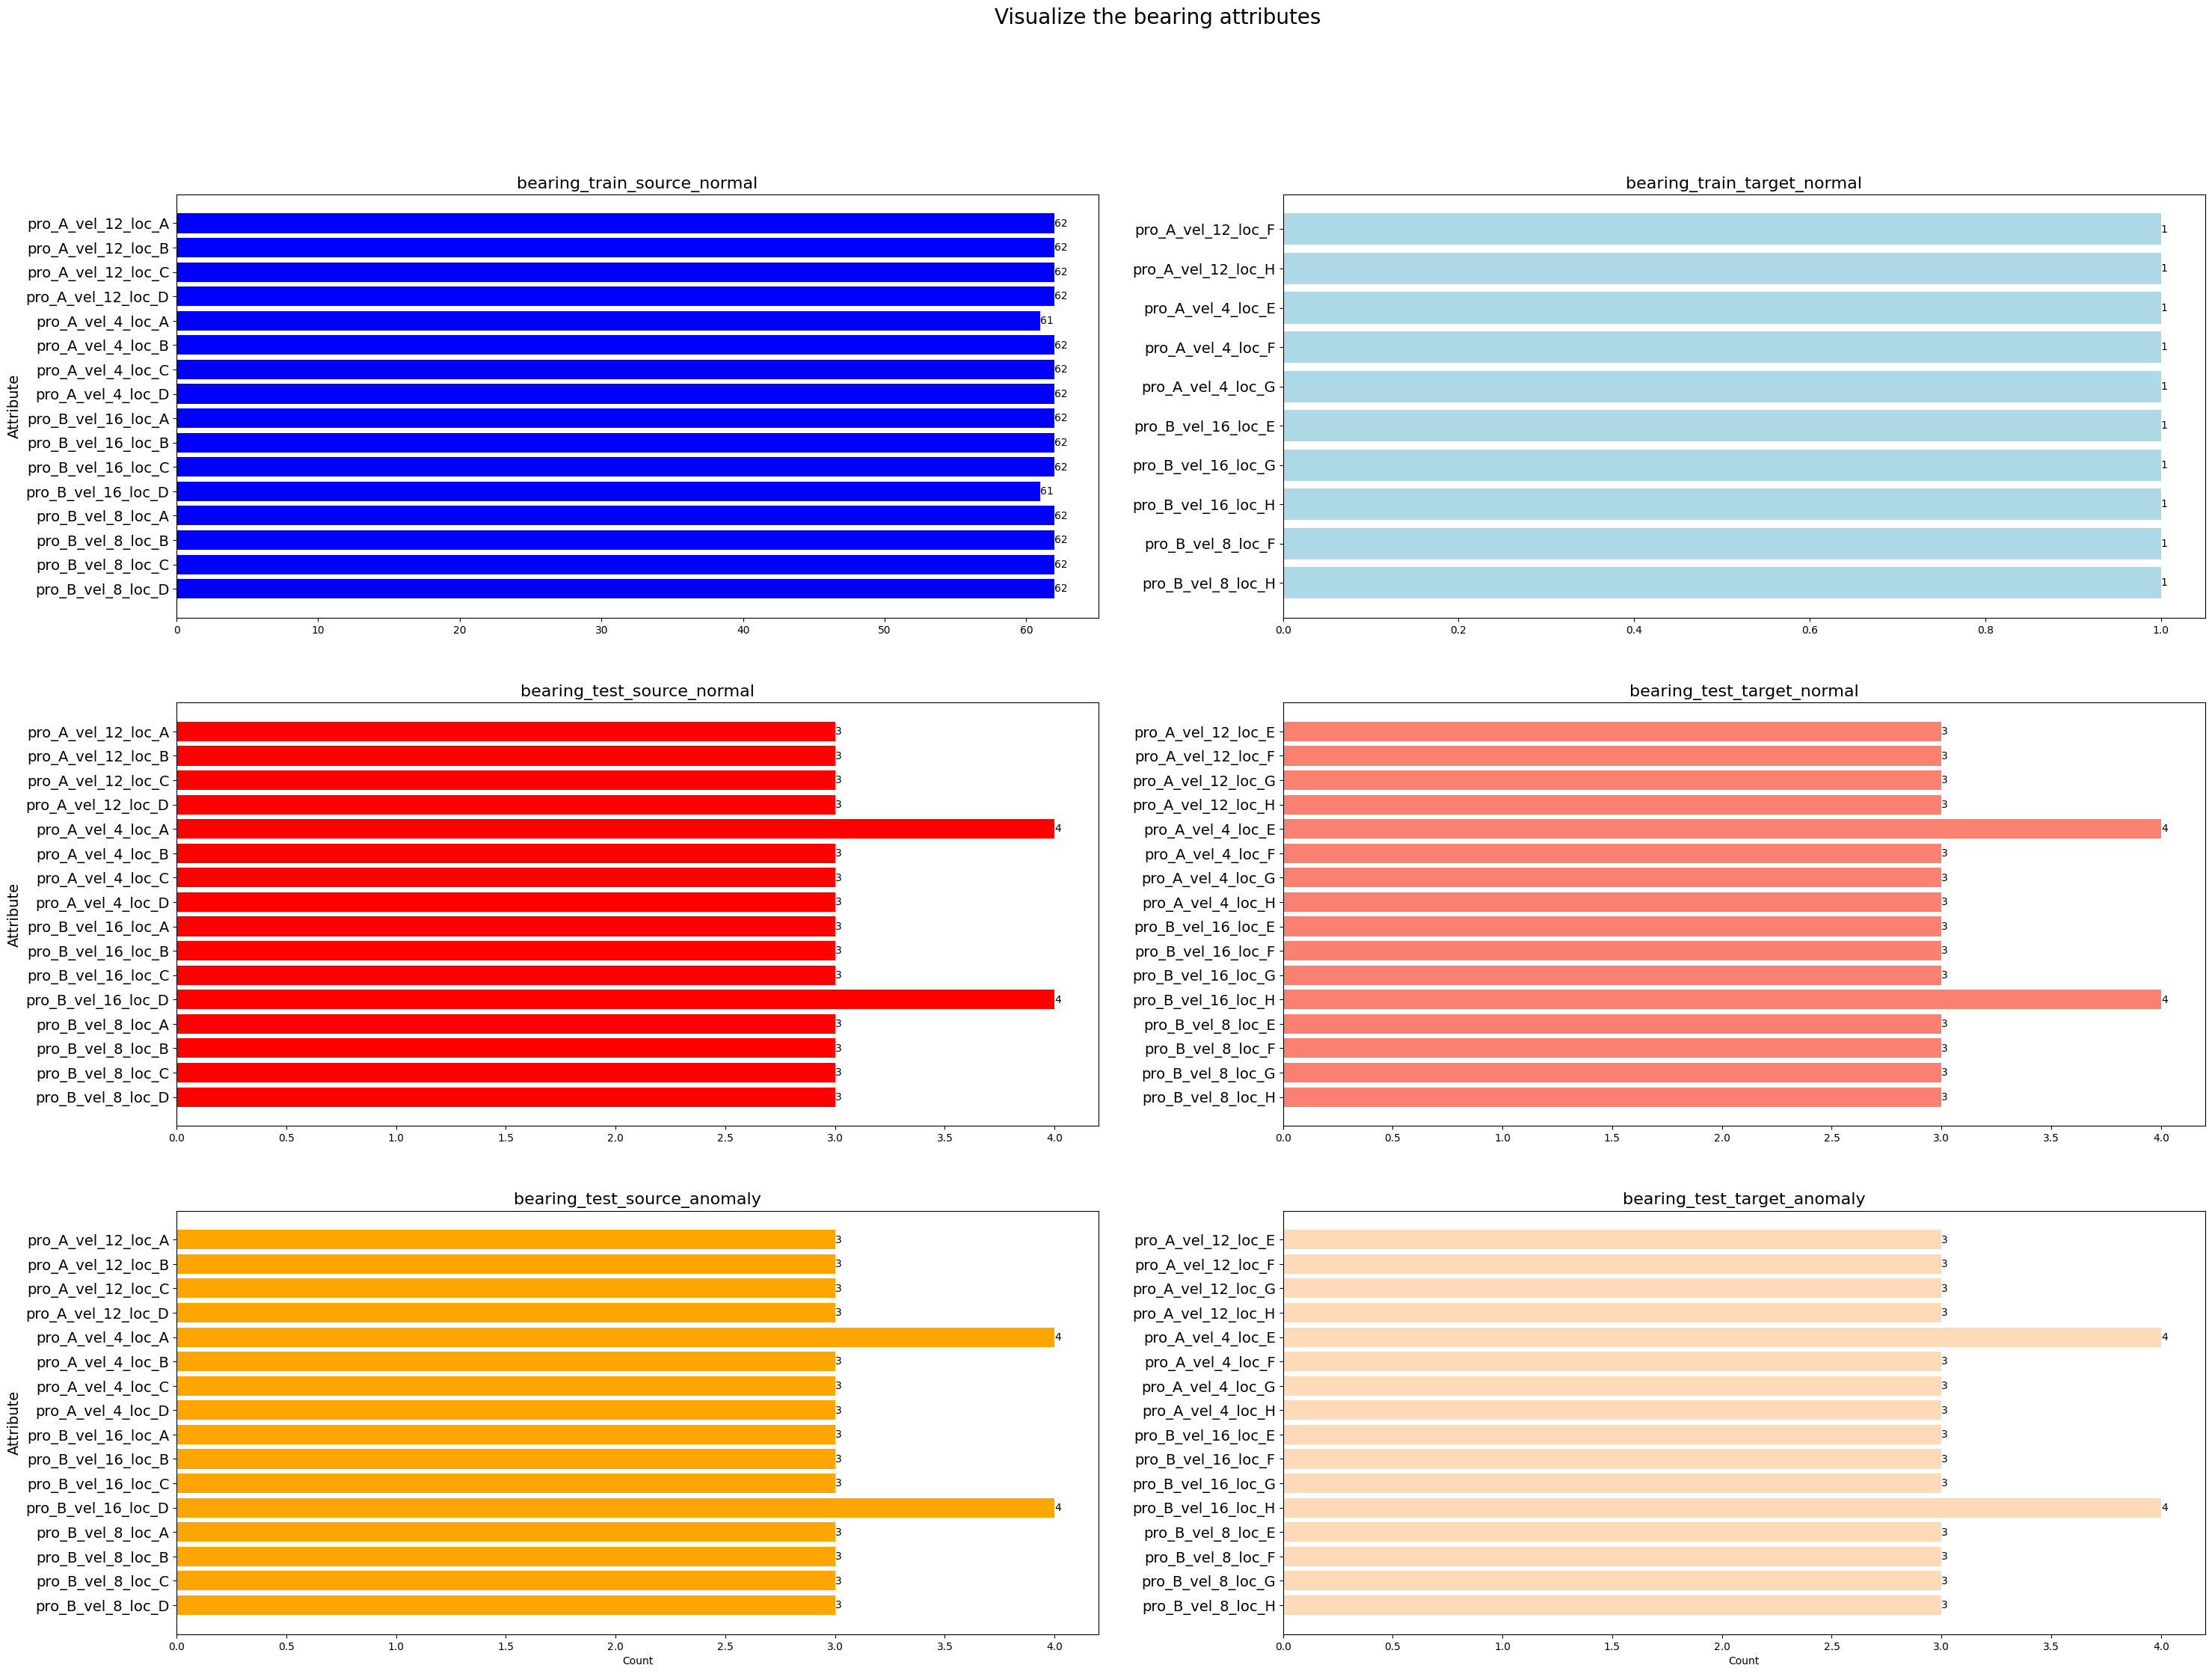

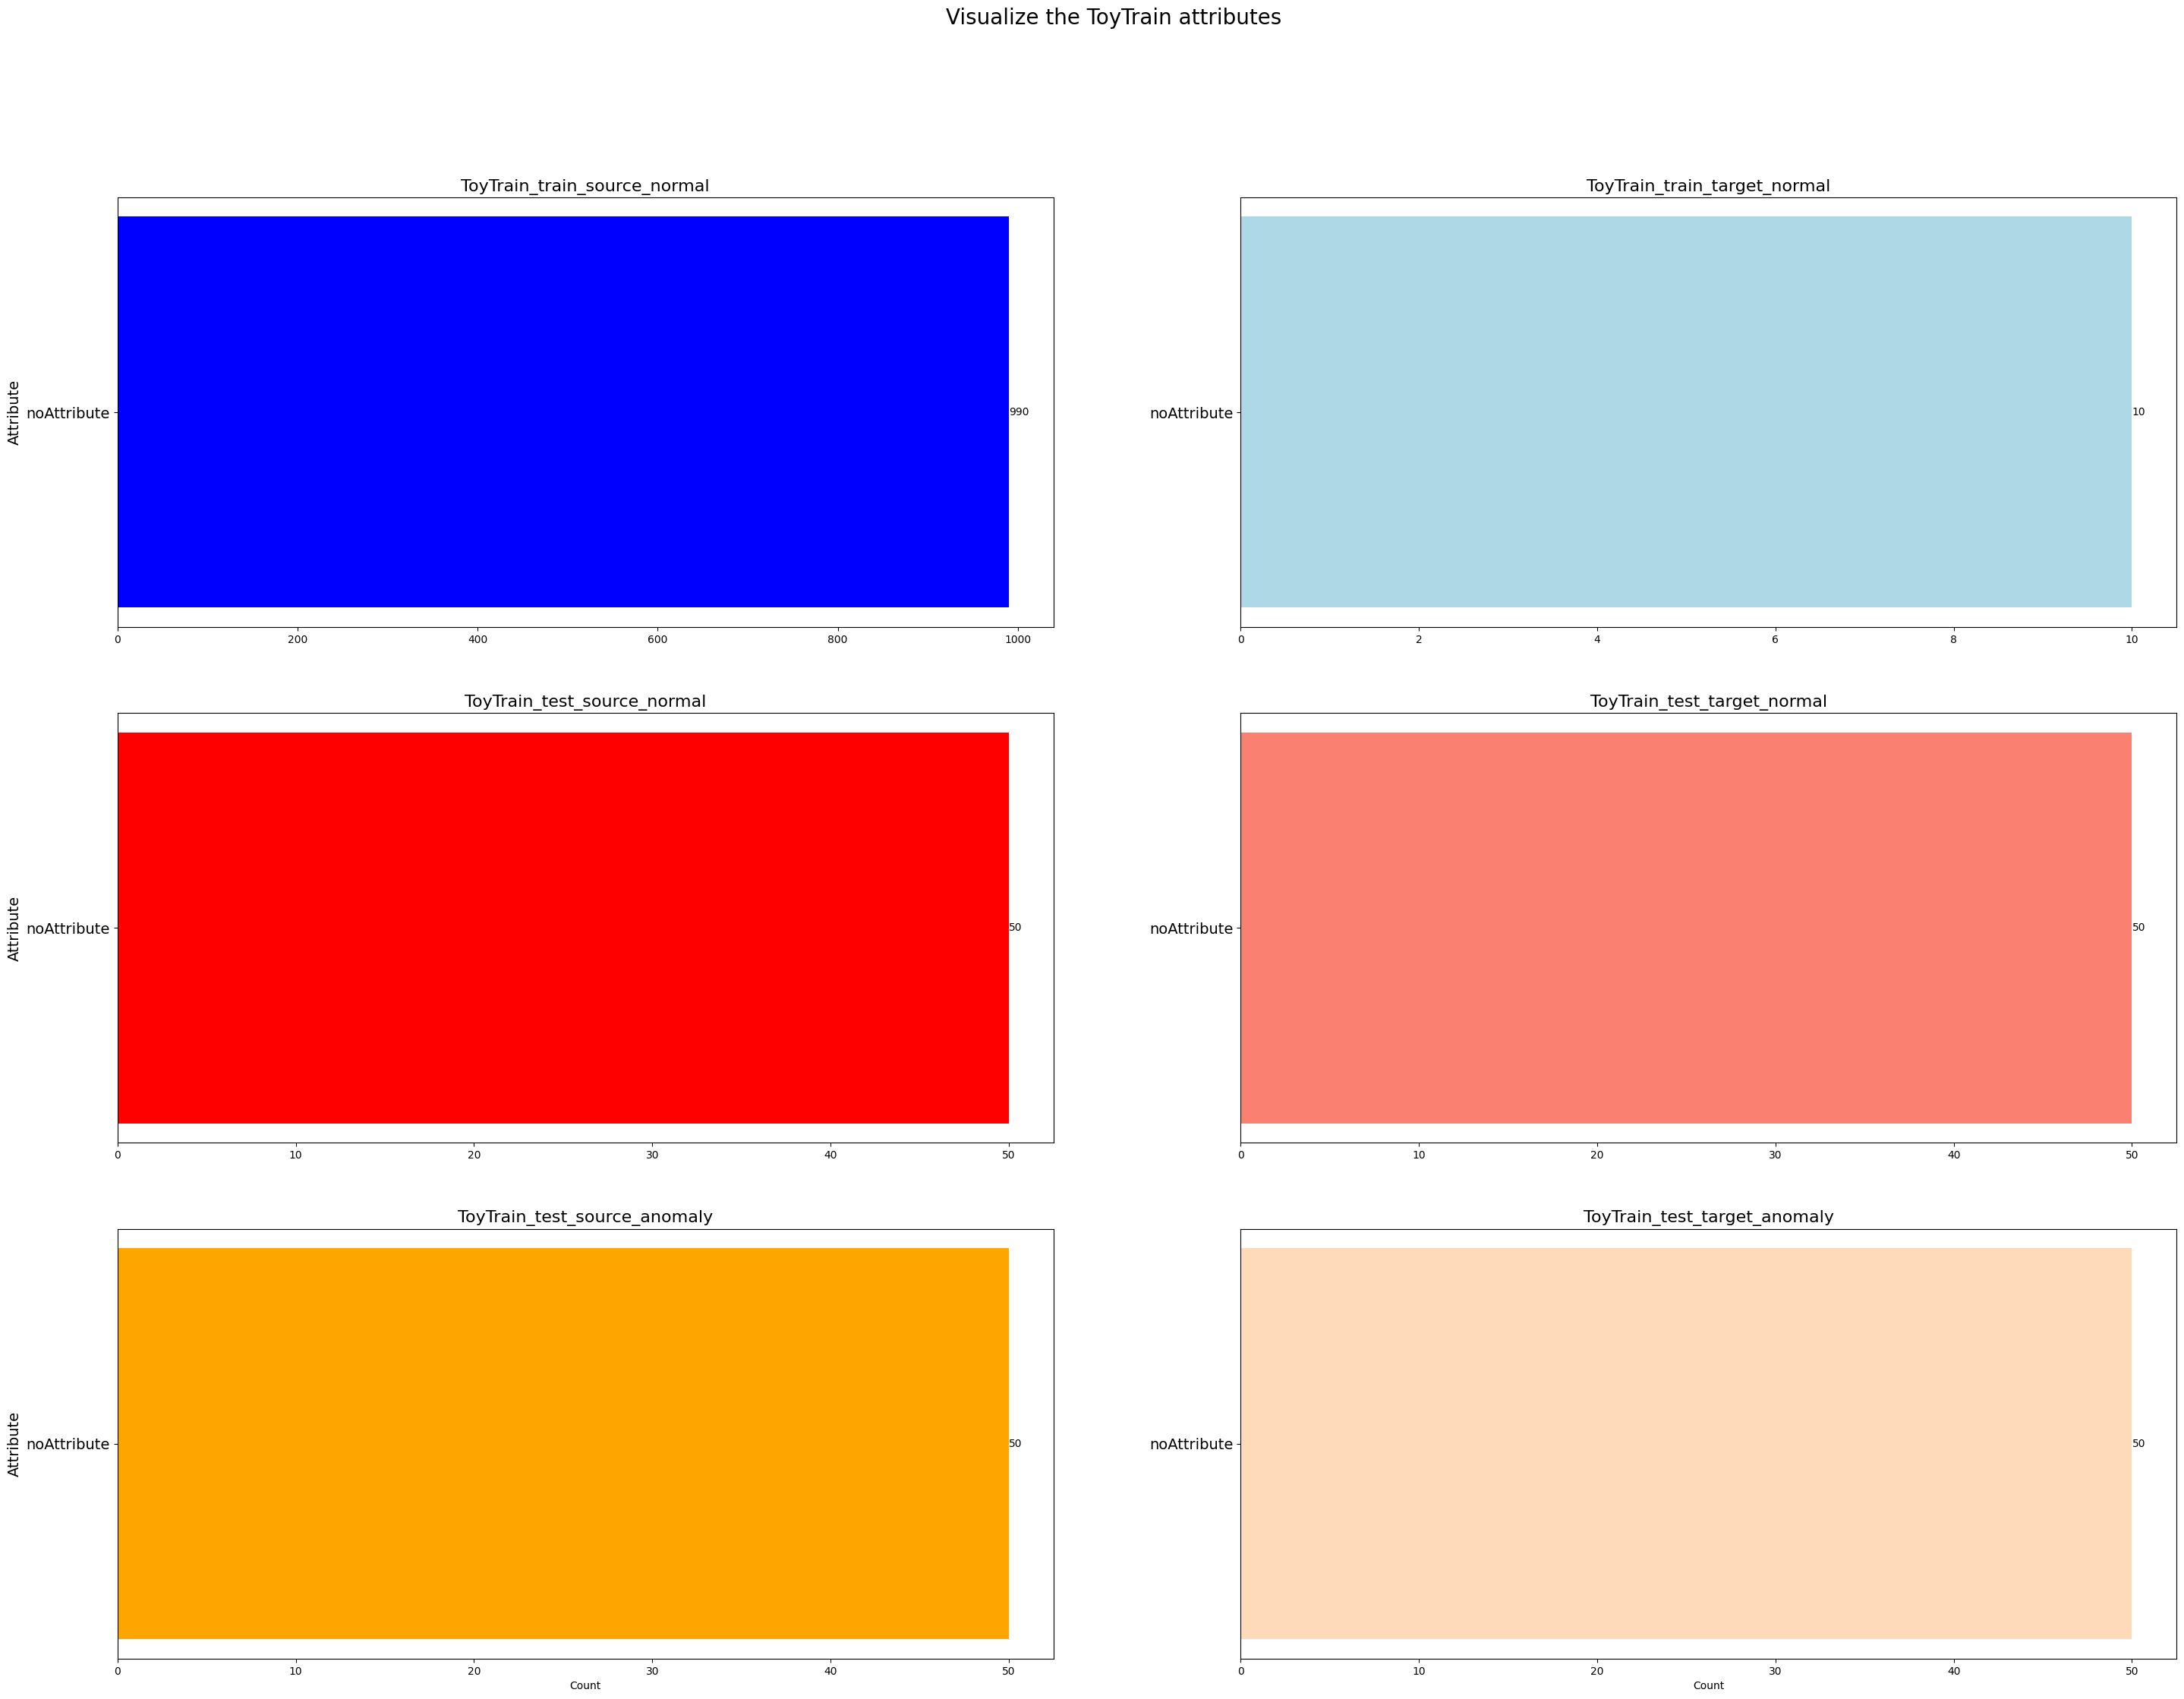

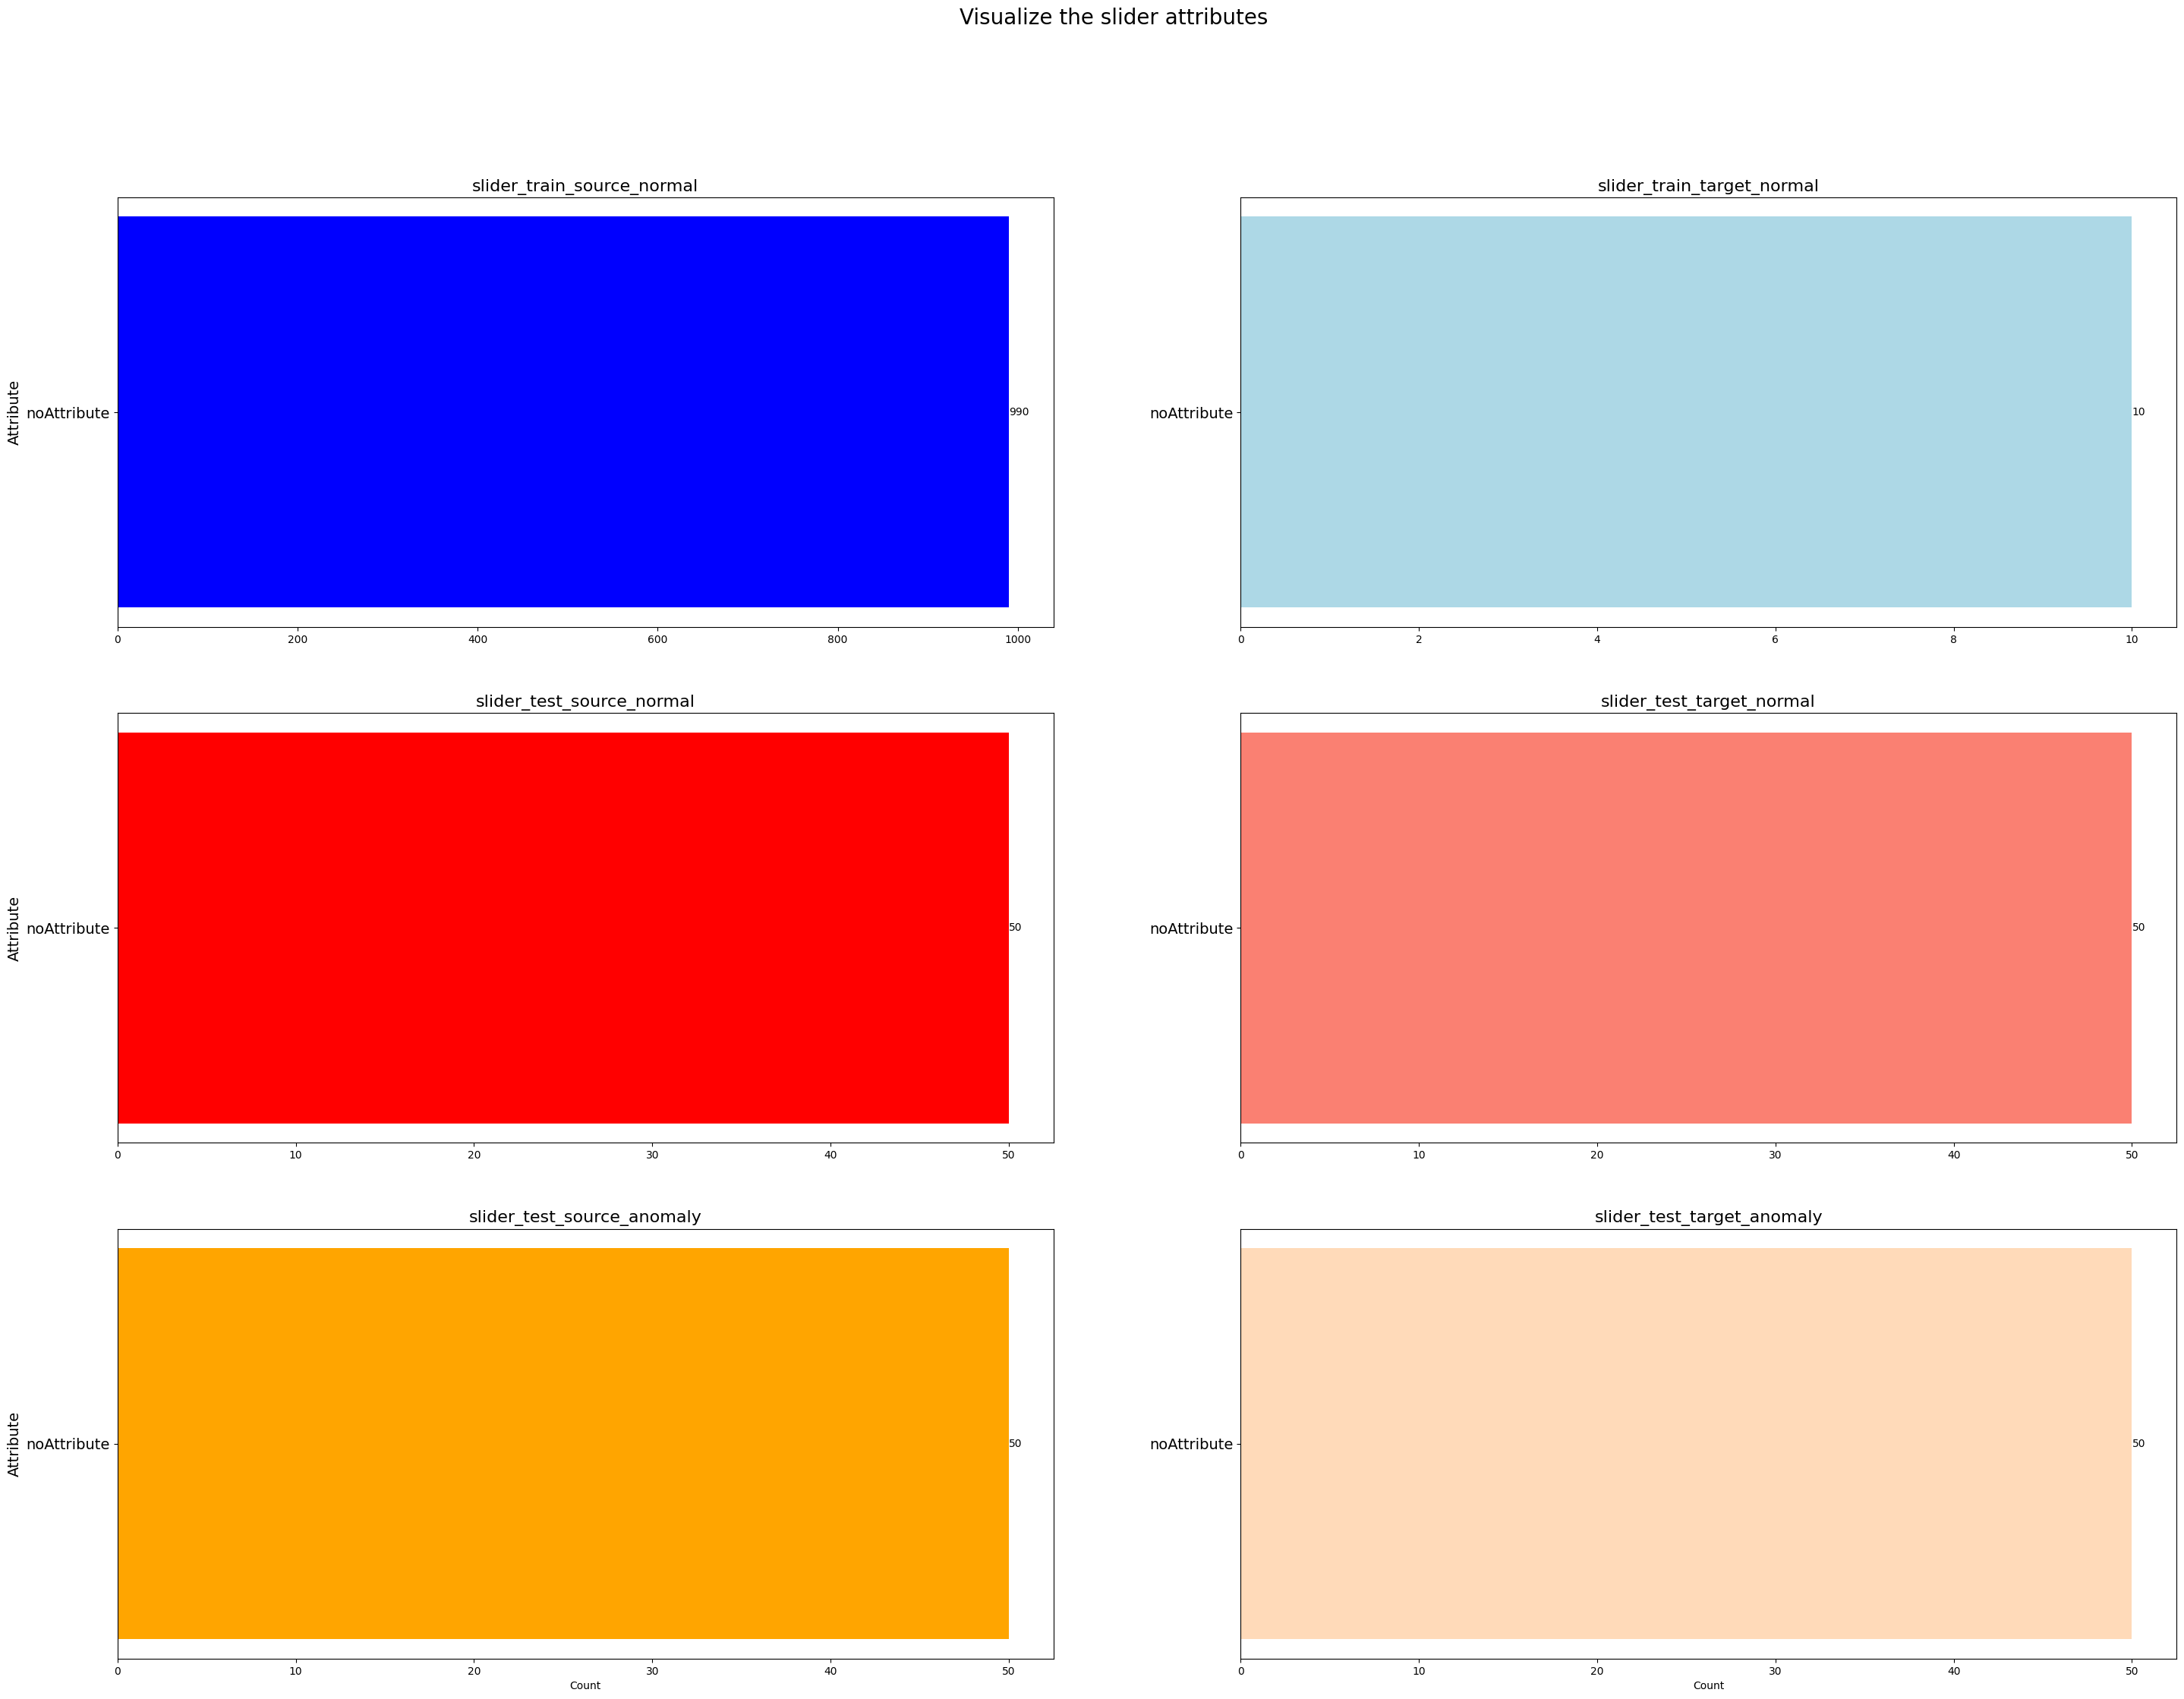

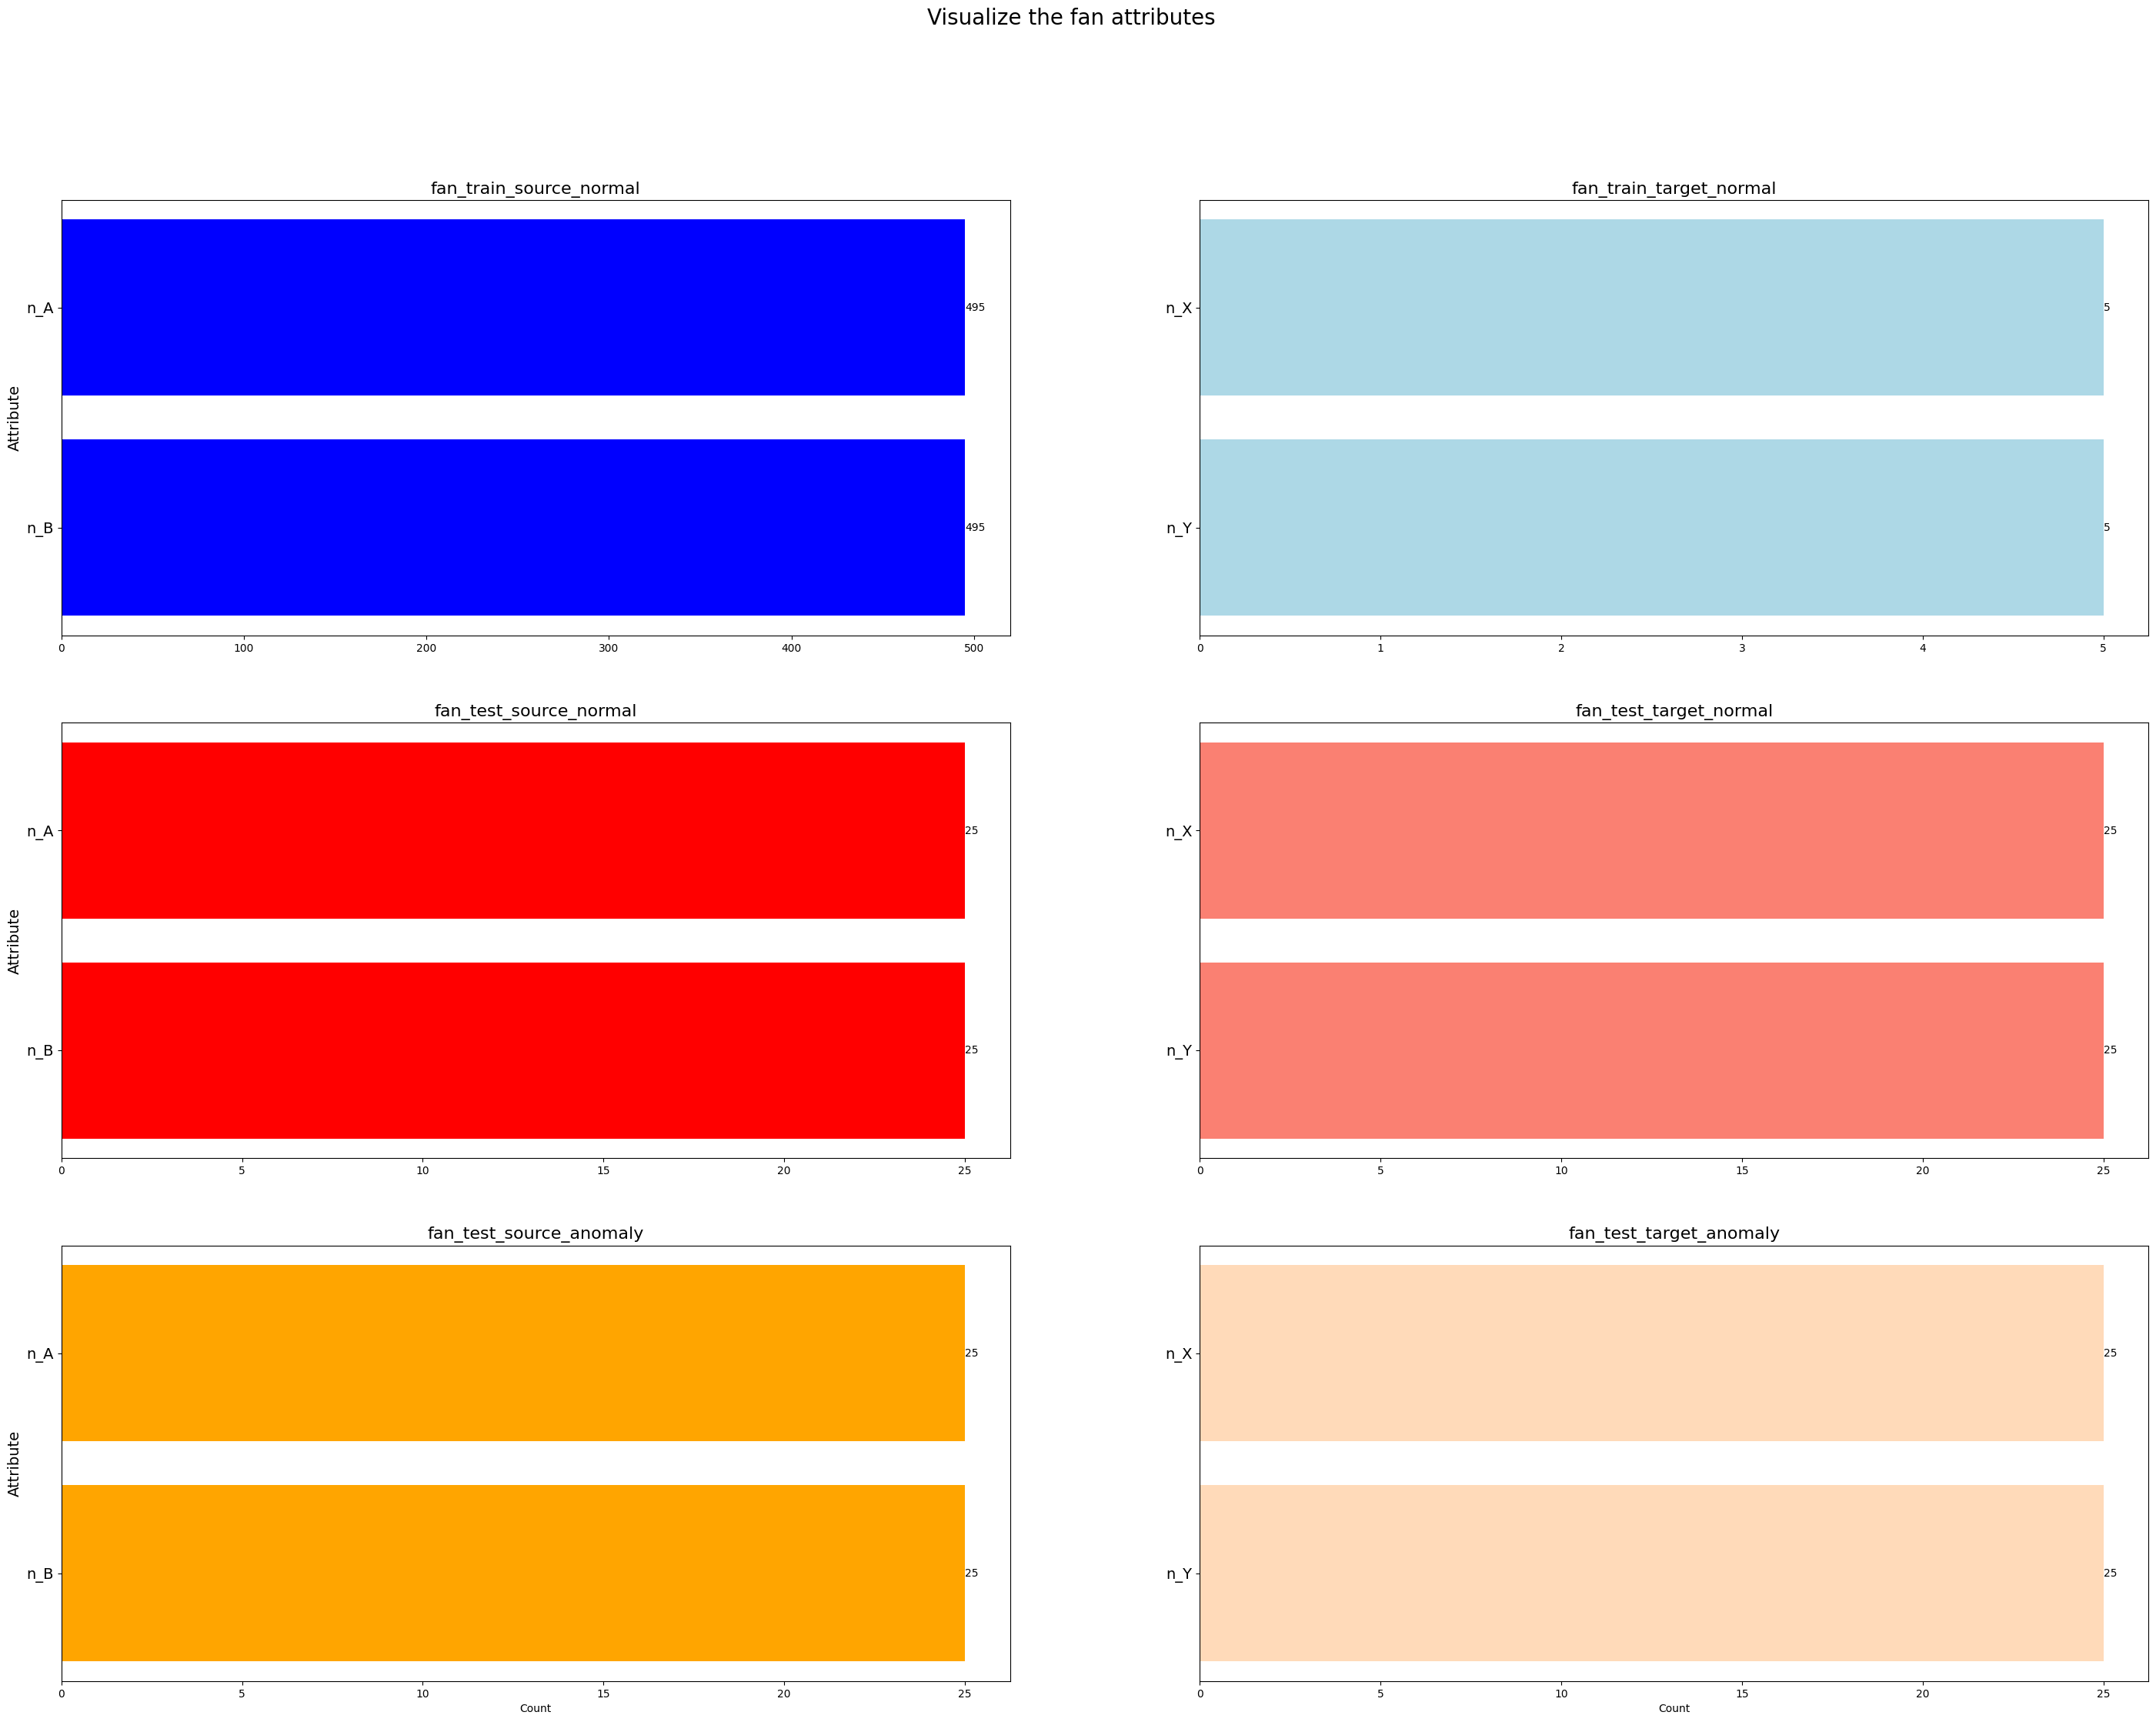

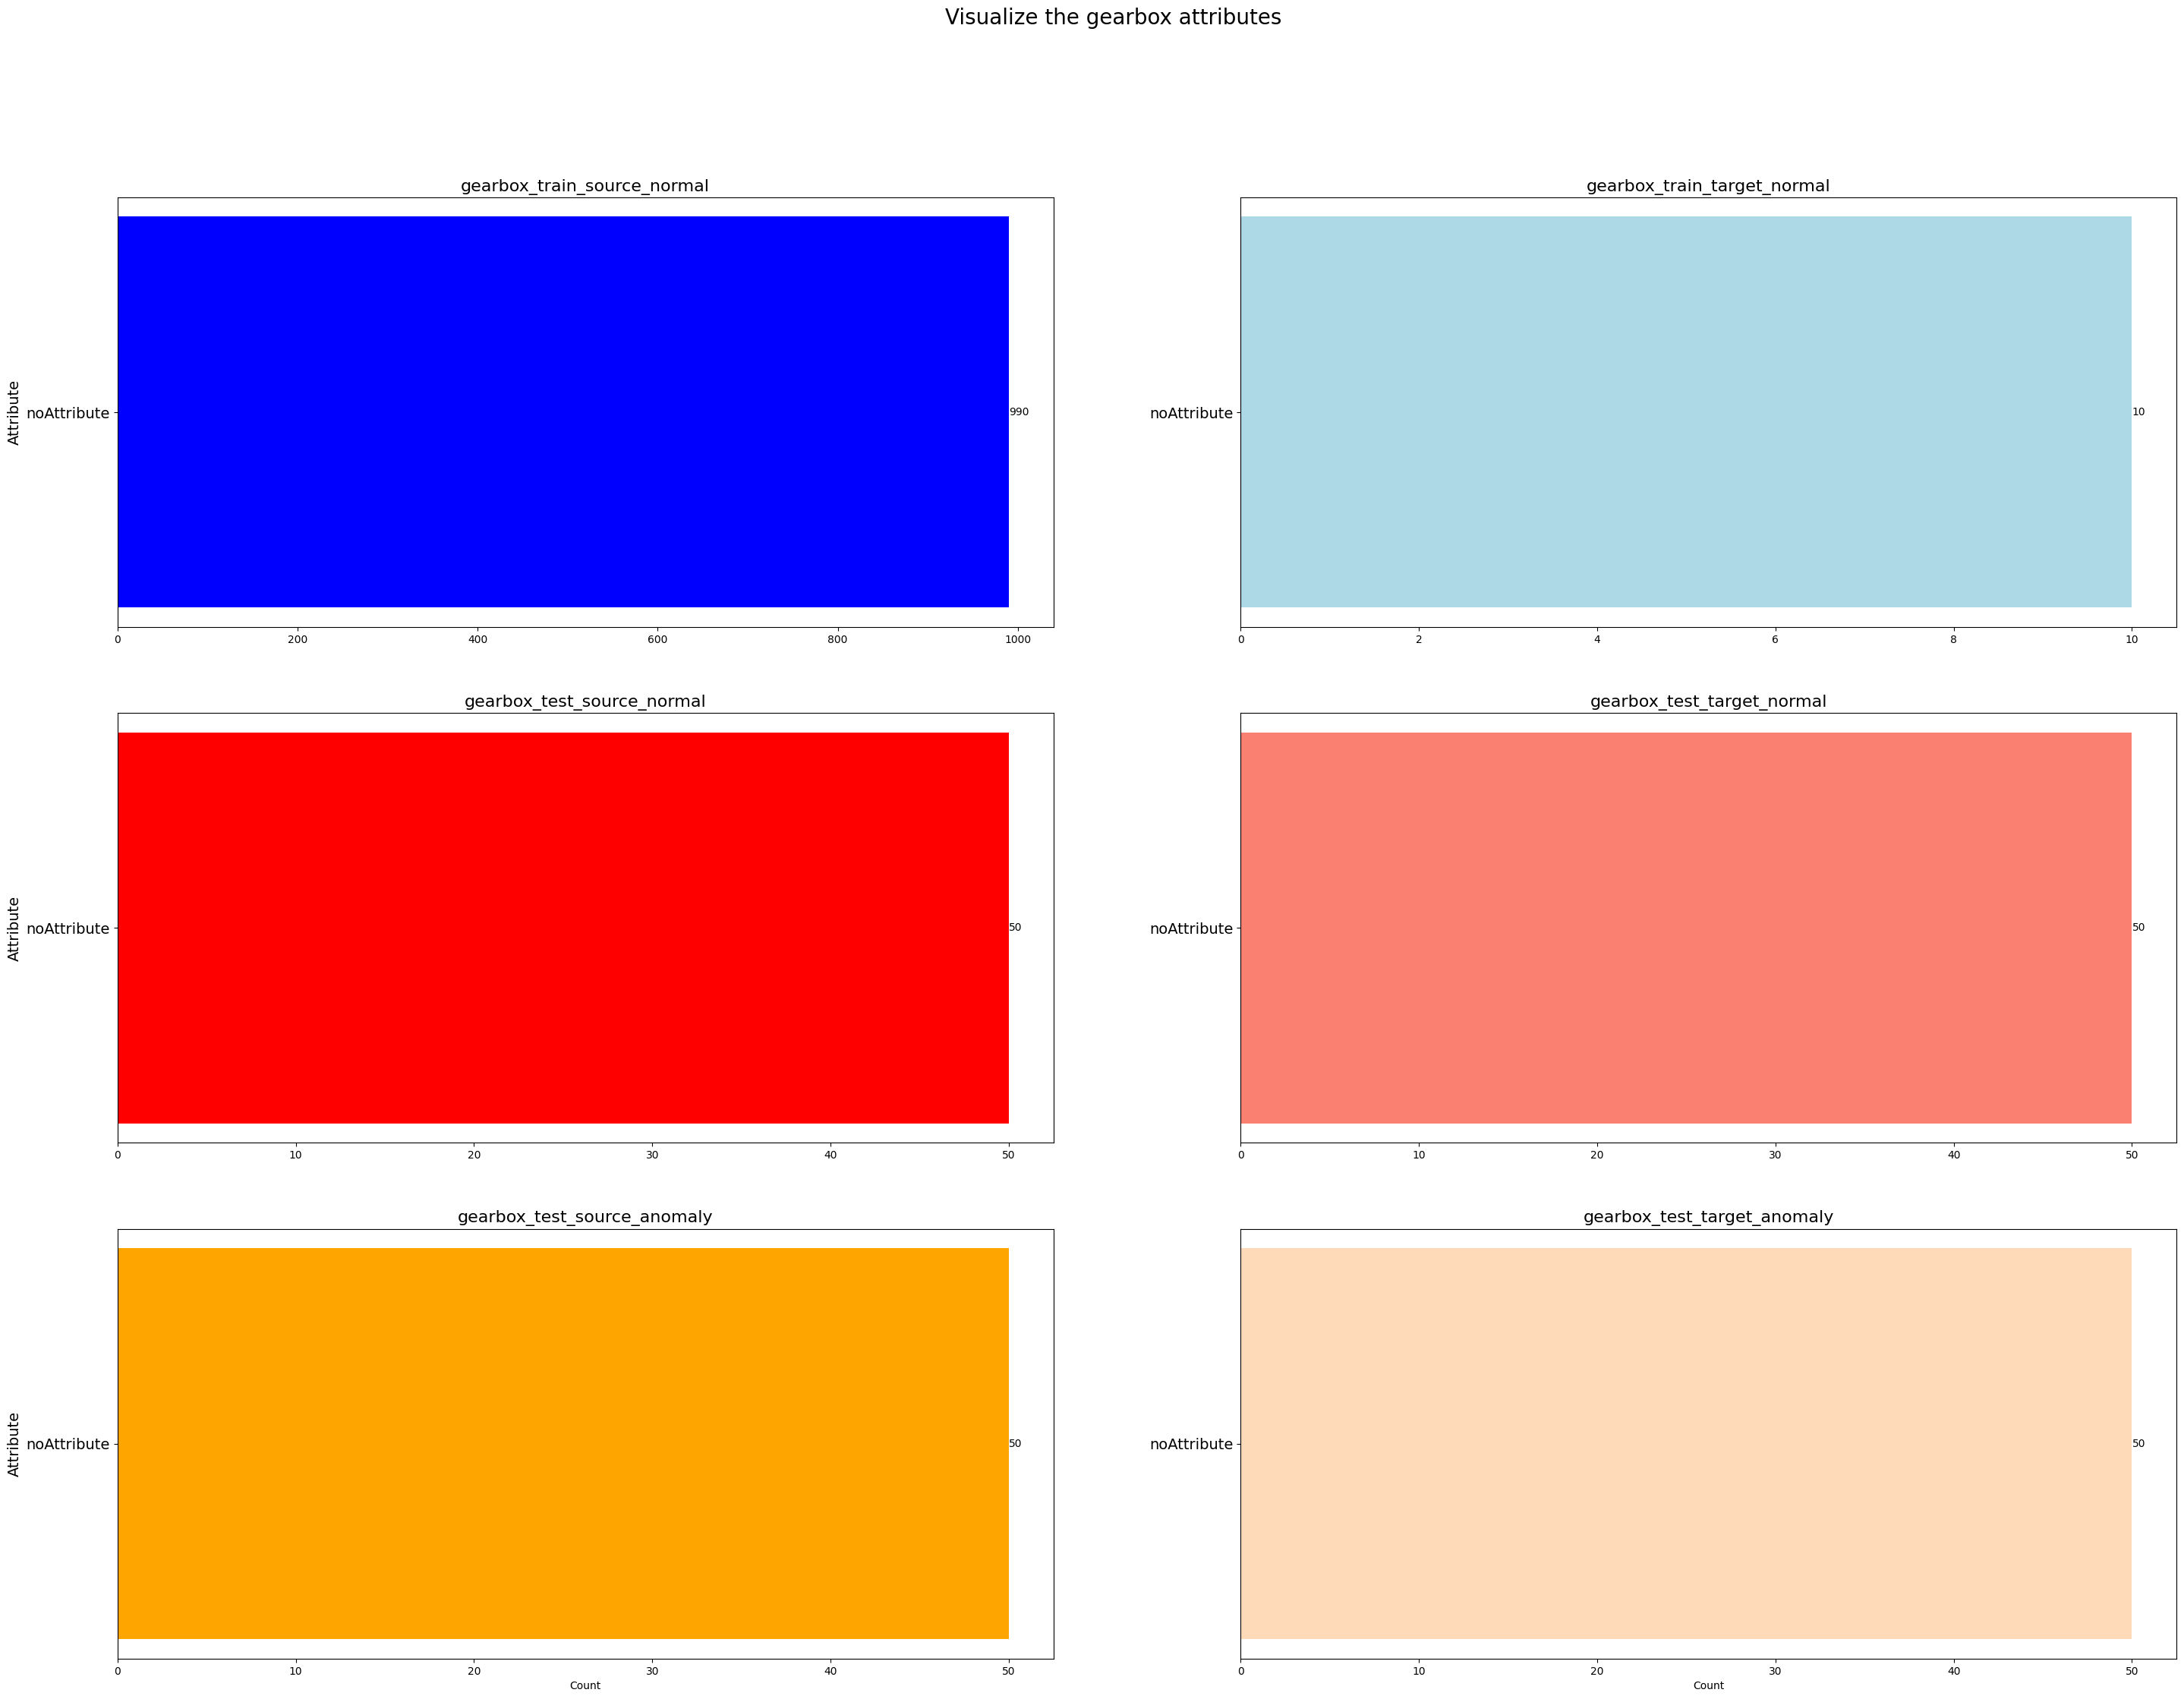

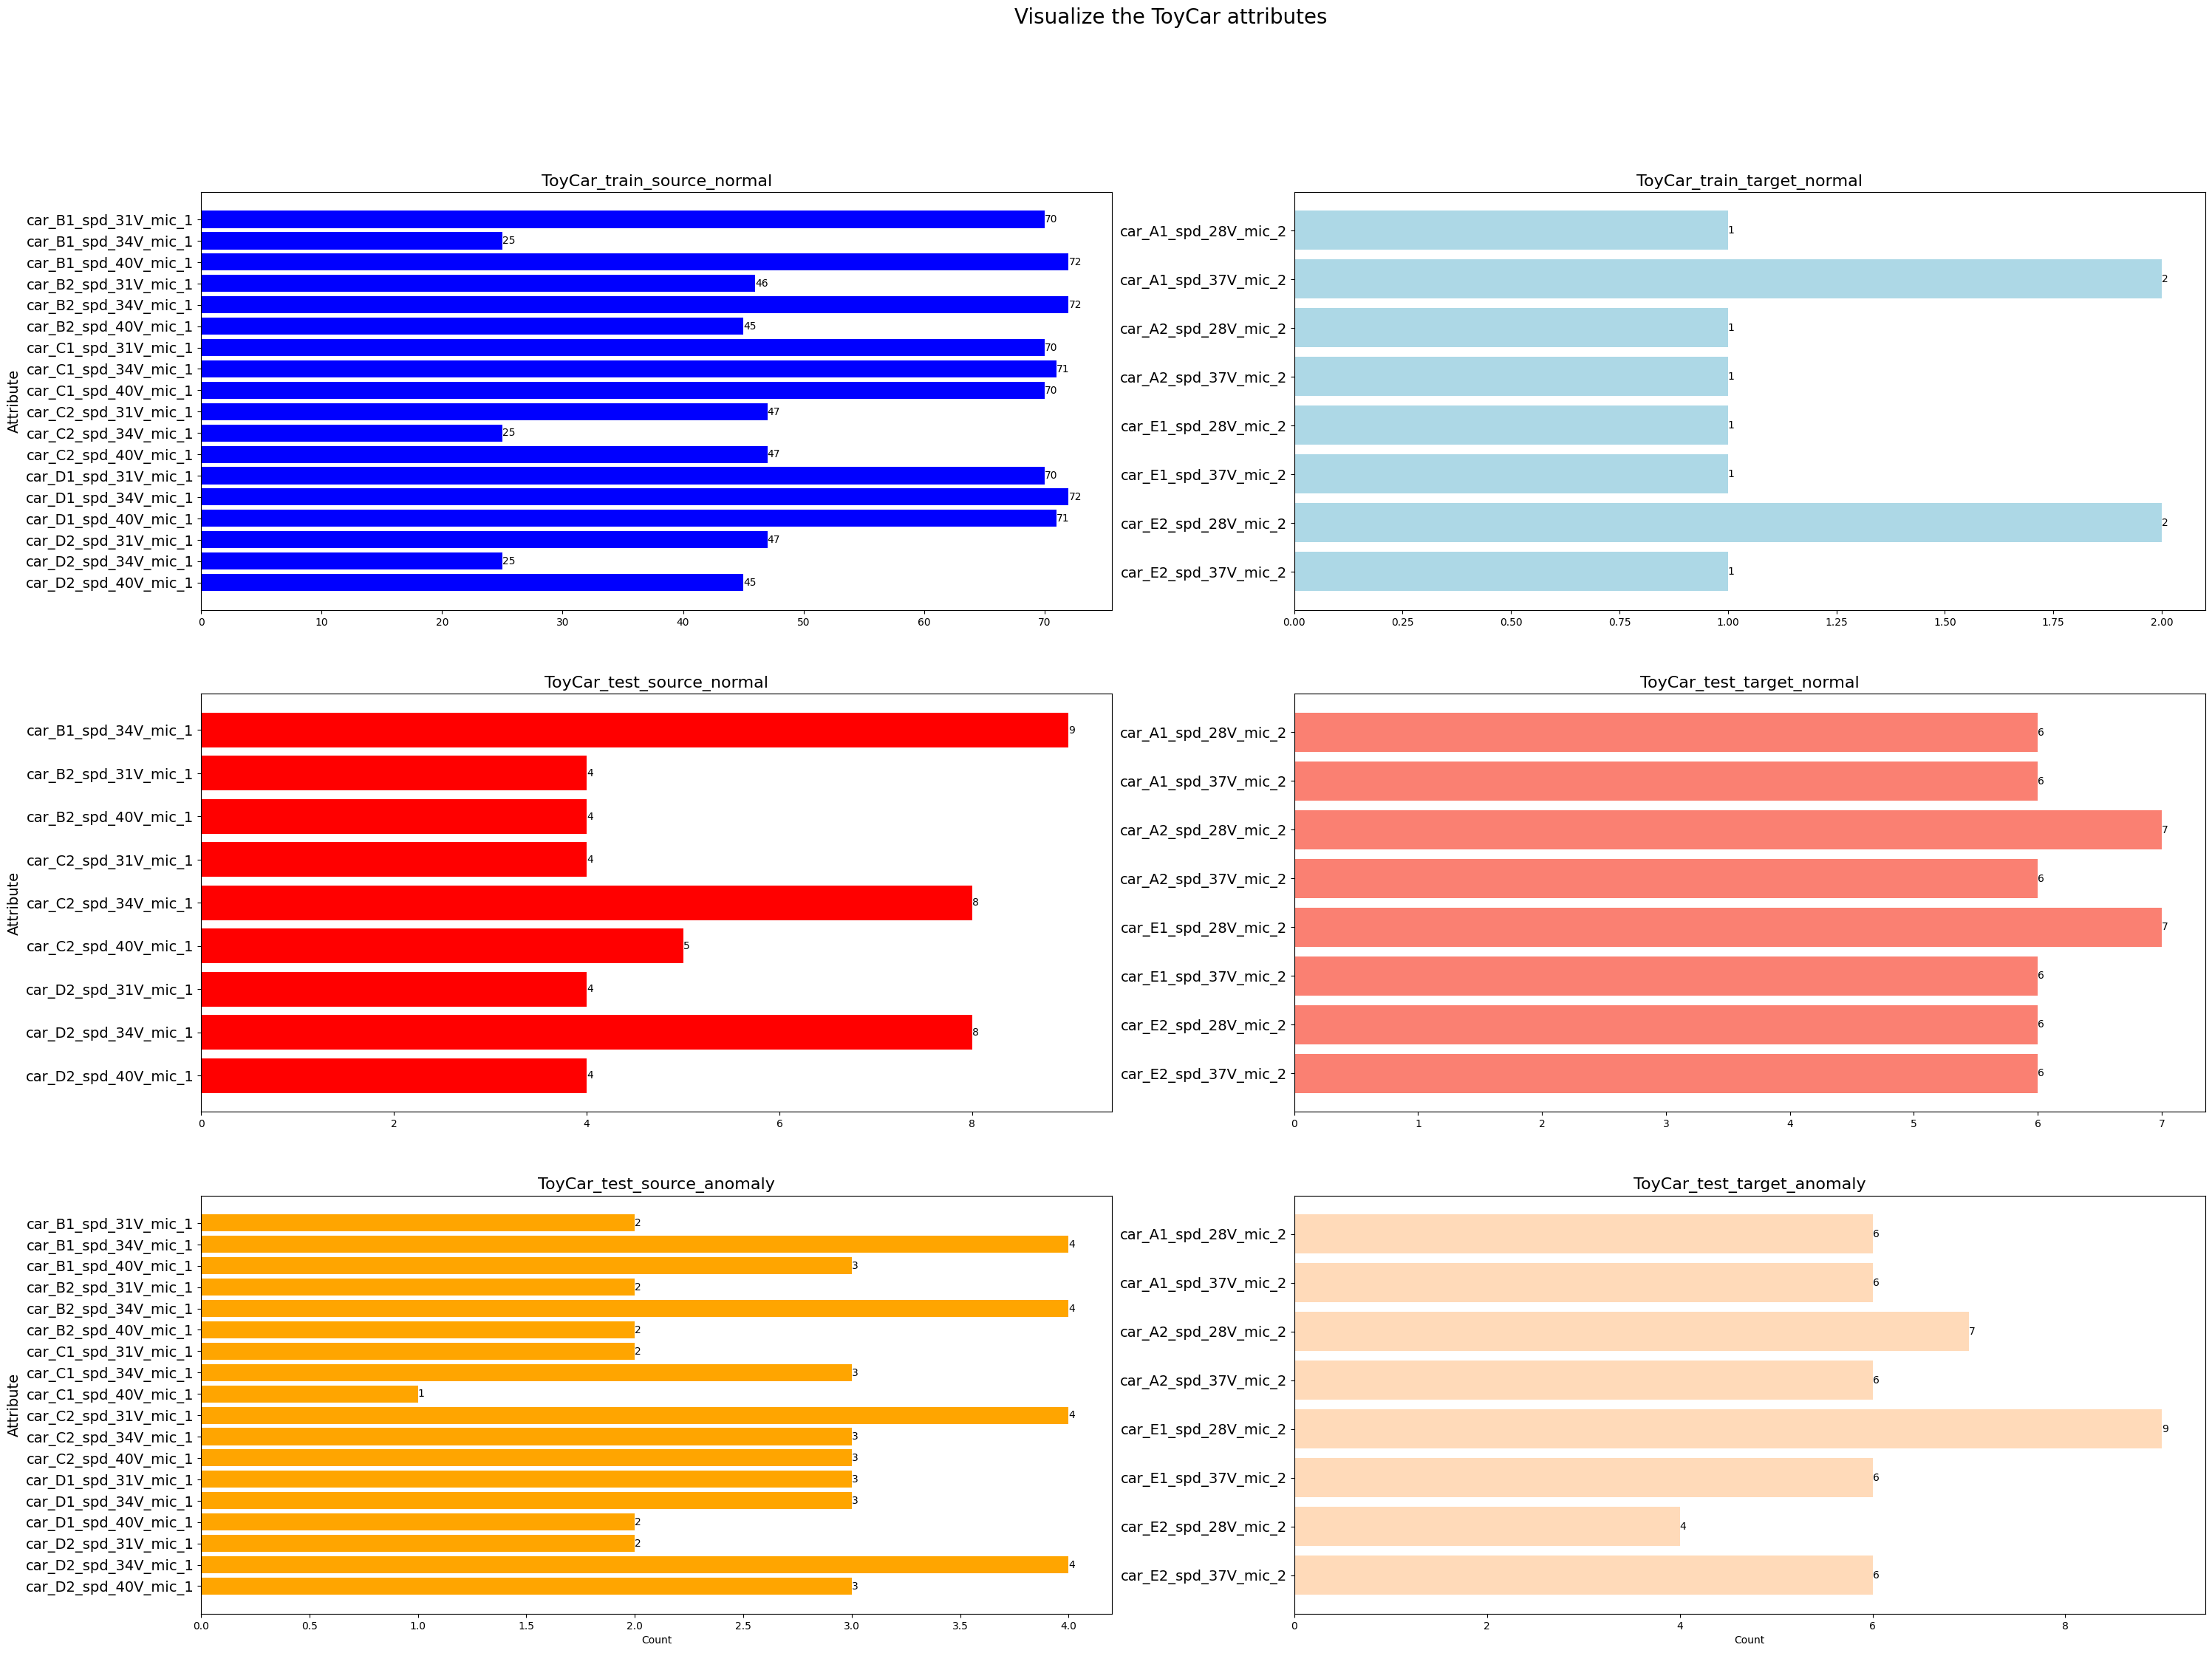

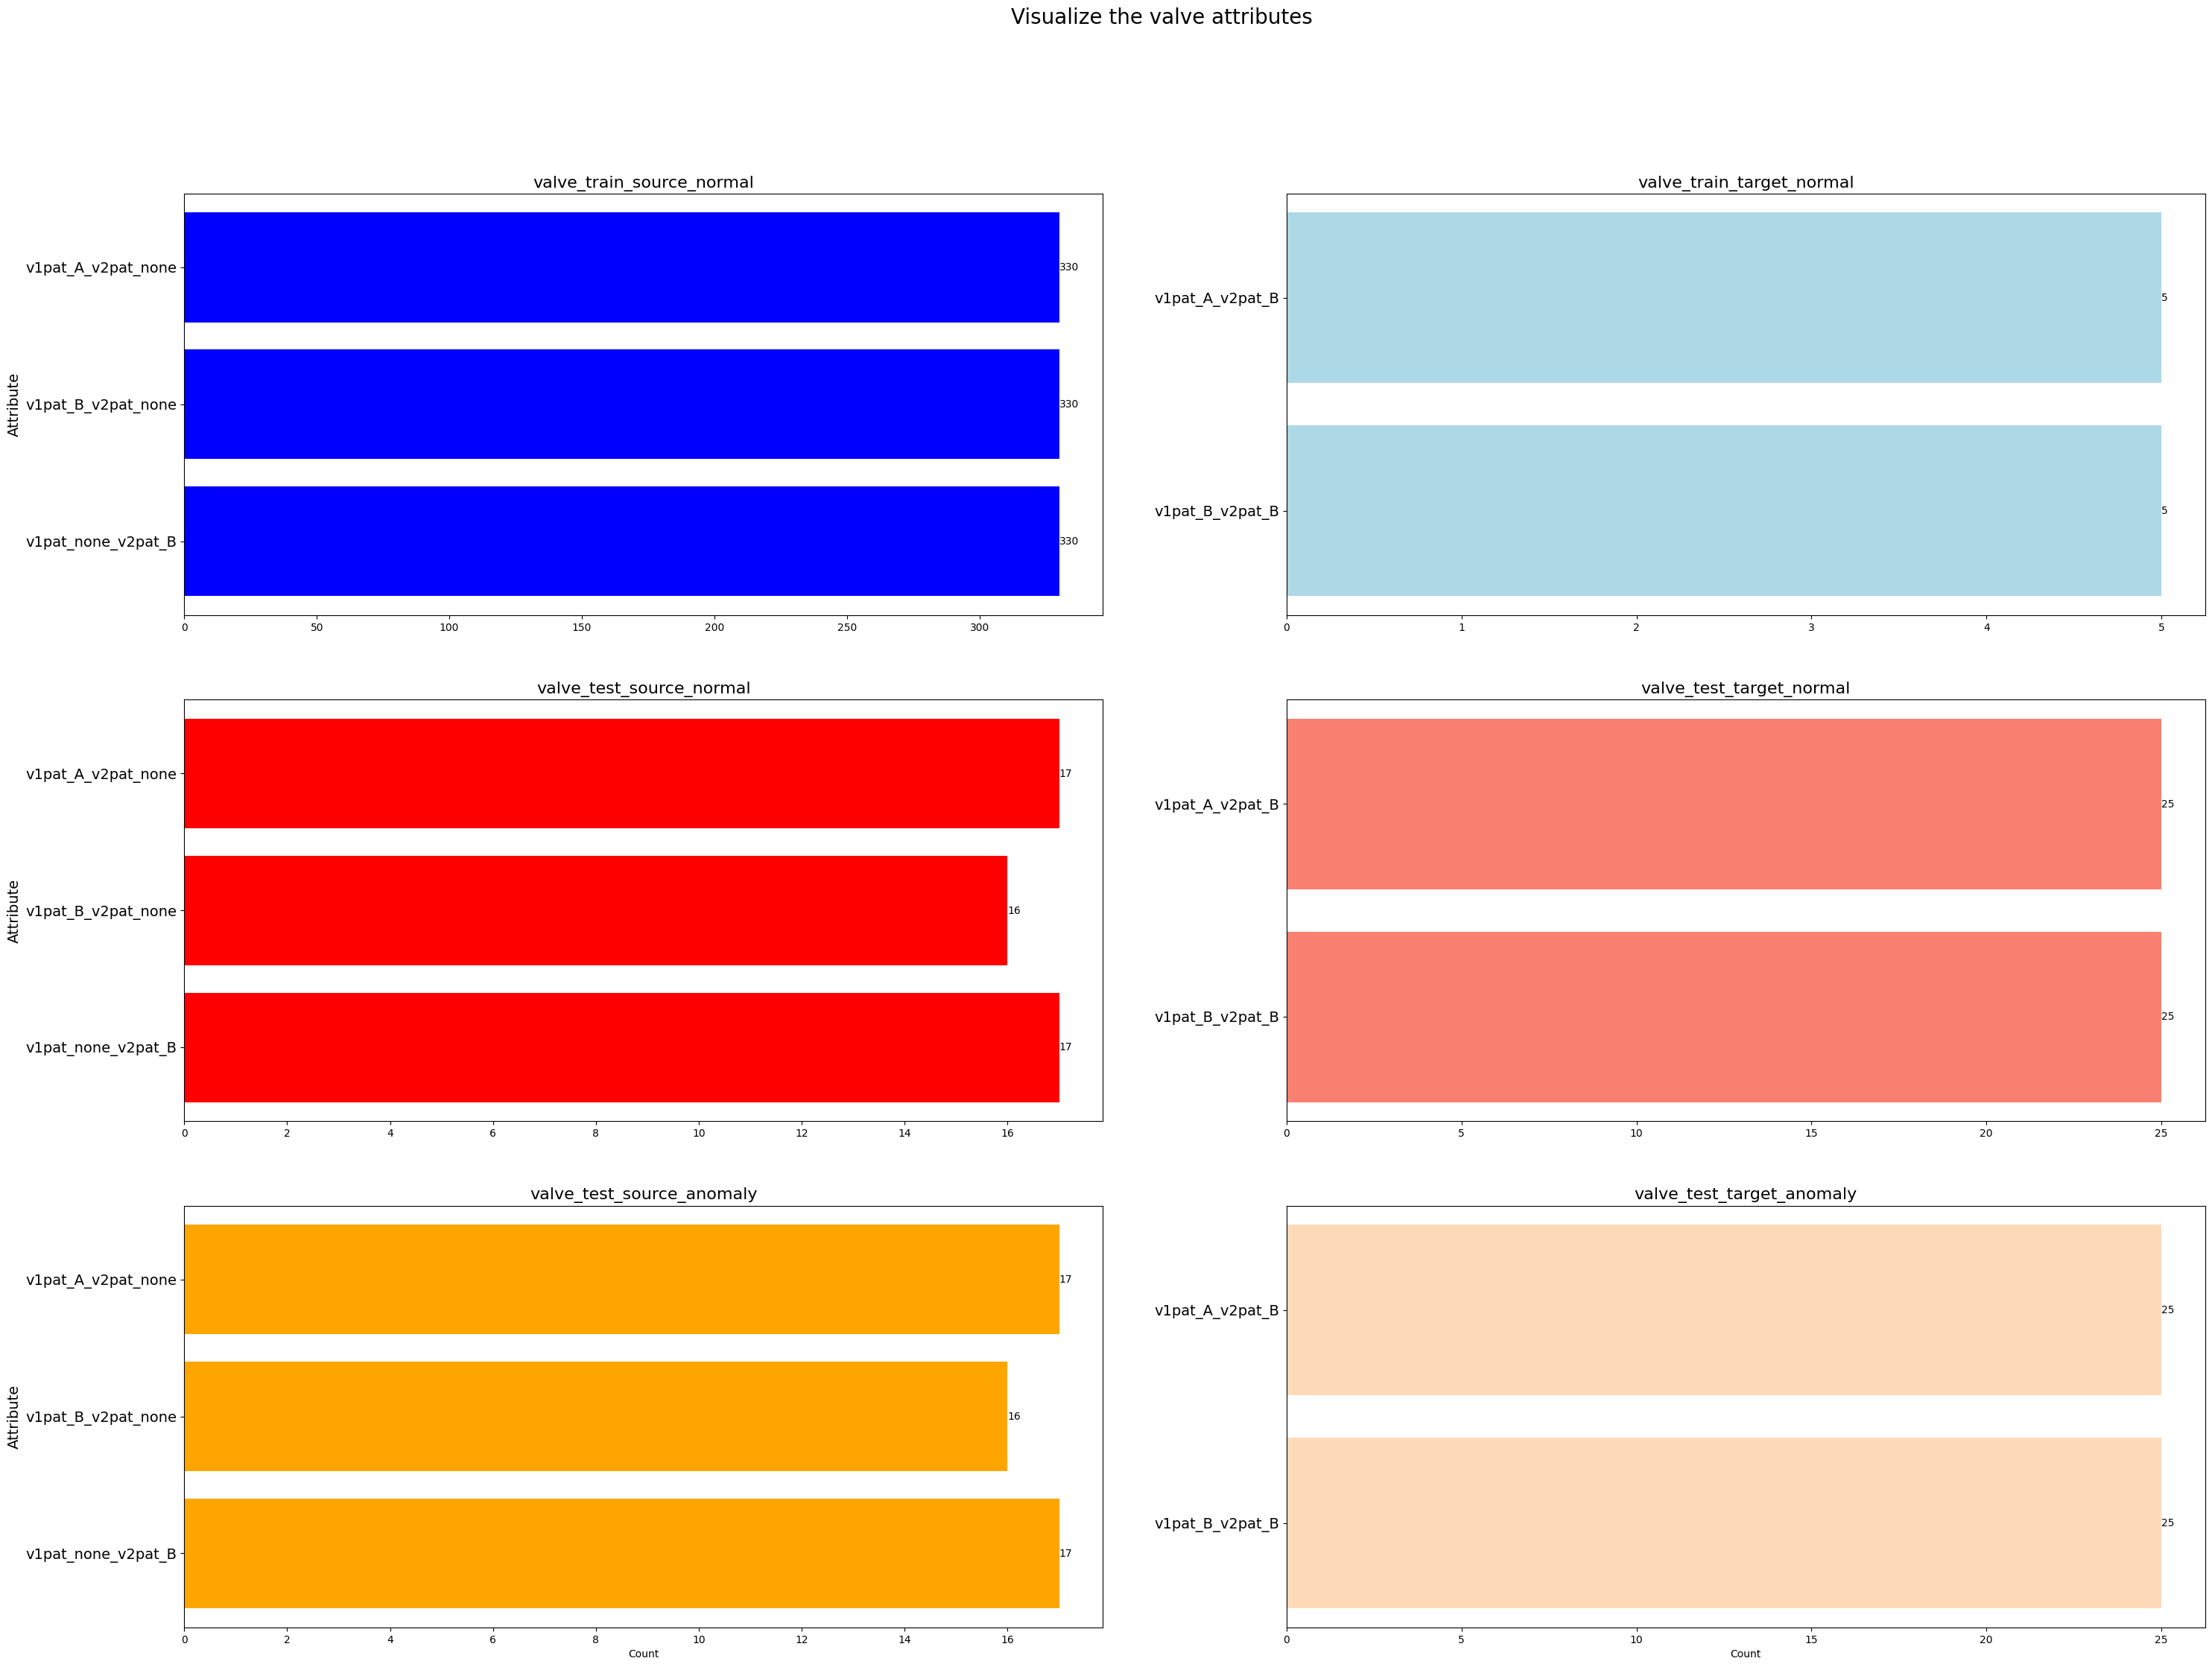

In [10]:
#visualize the attributes as bar plot
def visualize_as_bar (machine_choice):

    #loop through all machine 
    for machine in machine_choice:

        #plot the train and test data
        fig, axes = plt.subplots(figsize = (35,25),nrows=3,ncols=2)
        axes = axes.flatten()
        fig.suptitle("Visualize the {} attributes".format(machine),fontsize = 20)
        color = ["b", "lightblue", "r", "salmon", "orange", "peachpuff"]

        for i in range(len(axes)):

            #create the axes
            ax = axes[i]
            c = color[i]

            #choose key word in key:
            if i in [0, 1]:
                dict = {k: dict_unique_count[k] for k in dict_unique_count.keys() if machine in k and "train" in k}
                key = list(dict.keys())

            elif i in [2,3]:
                dict = {k: dict_unique_count[k] for k in dict_unique_count.keys() if machine in k and "test" in k and "normal" in k}
                key = list(dict.keys())

            else:
                dict = {k: dict_unique_count[k] for k in dict_unique_count.keys() if machine in k and "test" in k and "anomal" in k}
                key = list(dict.keys())
                ax.set_xlabel("Count")
                
            #choose the key and set title
            if i % 2 == 0:
                title_key = key[0]
                ax.set_ylabel("Attribute",fontsize = 14)
            else: 
                title_key = key[1]
                
            #load the attribute and their count
            dict_title = dict[title_key]
            att_key = np.flip(list(dict_title.keys()))
            att_value = np.flip(list(dict_title.values()))

            att_key = np.array([i.replace(".wav", "") for i in att_key])

            #plot the bar
            bars = ax.barh(att_key,att_value, color = c)
            ax.set_yticks(range(len(att_key)))
            ax.set_yticklabels(att_key, fontsize=14)

            #set title
            ax.set_title (title_key,fontsize=16)

            # Add values on top of each bar
            for bar, value in zip(bars, att_value):
                ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(value), ha='left', va='center')

visualize_as_bar(machine_choice)

In [ ]:
@interact(machine=machine_choice, data=data_choice, condition=condition_choice, domain=domain_choice)
def load_machine_data_domain(machine, data, domain):
    # Load path
    clip_path = os.path.join(dev_path, machine, data)
    clip_name = [i for i in os.listdir(clip_path) if ".DS_Store" not in i]

    # Condition based on data
    if data == "train":
        condition_choice = ["normal"]
    else:
        condition_choice = ["anomaly","normal"]
        
    @interact(condition=condition_choice)
    def load_condition(condition):
        
        # Load attribute
        clip_dict = {k: dict_unique_count[k] for k in dict_unique_count.keys() if machine in k and data in k and domain in k and condition in k}
        attribute_choice = list(clip_dict.values())[0].keys()

        @interact(attribute=attribute_choice)
        def load_attribute(attribute):
            # Load indices
            clip_attribute = [i for i in clip_name if attribute in i and condition in i]
            clip_indices = [i.split("_")[5] for i in clip_attribute]

            @interact(clip=clip_indices)
            def load_index(clip):
                # Load clip path
                clip_selection = [i for i in clip_attribute if clip in i][0]
                # print("clip_selection:", clip_selection)
                path_selection = os.path.join(clip_path, clip_selection)
                print("path_selection:", path_selection)

                # Display the audio clip
                display(IPython.display.Audio(path_selection))

                # Visualize with numpy array
                sampling_freq, timeseries = wavfile.read(path_selection)
                
                #standardize
                # scaler = StandardScaler()
                # timeseries = scaler.fit_transform(timeseries.reshape(-1,1)).reshape(len(timeseries),)
                
                timeseries = np.array(timeseries,dtype = np.float32)
                print("sampling_freq:", sampling_freq)

                duration = len(timeseries) / sampling_freq
                print("duration:", duration)

                duration_array = np.linspace(0, duration, len(timeseries))
                plt.figure(figsize=(20, 10))
                plt.plot(duration_array, timeseries)
                plt.title(clip_selection)
                plt.xlabel("Duration (s)")
                plt.ylabel("Magnitude")

                # Parameter for Log Mel Spectrogram
                n_mels = Dropdown(options=[64, 128, 256, 512], value=128)
                window_size = IntSlider(min=80, max=8000, value=400, step=80)
                hop_size = IntSlider(min=40, max=4000, value=160, step=40)
                db = Dropdown(options=[True, False], value=True)

                @interact(window_size=window_size, hop_size=hop_size, n_mels=n_mels,db=db)
                def log_melspectrogram(window_size, hop_size, n_mels, db):
                    #calculate log melspectrogram
                    ms = librosa.feature.melspectrogram(y=timeseries, sr=sampling_freq, n_fft=window_size, hop_length=hop_size, n_mels=n_mels)
                    mel_f = librosa.mel_frequencies(n_mels=n_mels,fmin=0,fmax=sampling_freq /2)
                    if db:
                        ms = librosa.power_to_db(ms)
                    plt.figure(figsize=(10, 5))
                    plt.subplot(1, 2, 1)
                    librosa.display.specshow(ms,x_axis="time",y_axis="mel",cmap= None,hop_length=hop_size,sr=sampling_freq)
                    # plt.pcolormesh(np.linspace(0, duration, ms.shape[1]), mel_f, ms)
                    plt.title("Mel Spectrogram")
                    plt.xlabel("Time (s)")
                    plt.ylabel("Frequency (Hz)")

interactive(children=(Dropdown(description='machine', options=('ToyCar', 'ToyTrain', 'bearing', 'fan', 'gearbo…

# References

[DCASE2024](https://dcase.community/challenge2024/task-first-shot-unsupervised-anomalous-sound-detection-for-machine-condition-monitoring)